In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
def split_data(df, choose):
  if choose == 1: # 7:2:1
    train_size = int(len(df) * 0.7)
    test_size = int(len(df) * 0.2)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]

  elif choose == 2: # 5:3:2
    train_size = int(len(df) * 0.5)
    test_size = int(len(df) * 0.3)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]

  elif choose == 3: # 6:2:2
    train_size = int(len(df) * 0.6)
    test_size = int(len(df) * 0.2)
    val_size = len(df) - train_size - test_size

    train_data = df[:train_size]
    test_data = df[train_size:train_size + test_size]
    val_data = df[train_size + test_size:]


  print("Train: ", train_size)
  print("Test: ", test_size)
  print("Val: ", val_size)

  return train_data, test_data, val_data


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Project/dataset/NFLX_Stock.csv',usecols=['Date', 'Price'], parse_dates=['Date'], index_col='Date')
df.head()

,Price
Date,
2017-12-01,186.82
2017-12-04,184.04
2017-12-05,184.21
2017-12-06,185.30
2017-12-07,185.20


In [ ]:

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

train_data, test_data, val_data = split_data(scaled_data , 1)

Train:  974
Test:  278
Val:  140


In [ ]:
n_steps = 10
n_features = 1

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

# Tạo input sequences cho training, validation, và testing
X_train, y_train = create_sequences(train_data, n_steps)
X_val, y_val = create_sequences(val_data, n_steps)
X_test, y_test = create_sequences(test_data, n_steps)


In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

#### CNN

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

In [ ]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 9, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 64)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 4, 64)             0         
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 100)               25700     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                        

In [ ]:
model.compile(loss='mean_squared_error', optimizer=tf.optimizers.Adam(learning_rate=0.001))#, metrics=[MeanAbsolutePercentageError()])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Epoch 1/100
31/31 [==============================] - 11s 11ms/step - loss: 0.0177 - val_loss: 0.0050
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0043
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0039
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0037
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0045
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0047
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 1

##### GridSearch CNN

In [ ]:
def build_cnn_model(activation):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation=activation, input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(100, activation=activation))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=tf.optimizers.Adam(learning_rate=0.001))

    return model

In [ ]:
cnn_model = KerasRegressor(build_fn=build_cnn_model, verbose=0)
param_grid = {'activation': ['relu', 'tanh', 'sigmoid','LeakyReLU']}

grid_tcn = GridSearchCV(estimator=cnn_model, param_grid=param_grid, cv=3, error_score='raise')
grid_tcn_result = grid_tcn.fit(X_train, y_train)

best_activation = grid_tcn_result.best_params_['activation']
print(f'Best activation: {best_activation}')

<ipython-input-12-52457029ca25>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  cnn_model = KerasRegressor(build_fn=build_cnn_model, verbose=0)


Best activation: relu


In [ ]:
model_best = build_cnn_model(best_activation)
history = model_best.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Epoch 1/100
31/31 [==============================] - 1s 9ms/step - loss: 0.0404 - val_loss: 0.0049
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0041
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0043
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0040
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 11/

##### Evaluation model

In [ ]:
def evaluation_model(model):
  # evaluate trên tập test
  loss_test = model.evaluate(X_test, y_test, verbose=0)
  print("loss_test: ", loss_test)

  # evaluate trên tập val
  loss_val = model.evaluate(X_val, y_val, verbose=0)
  print("loss_val: ", loss_val)

In [ ]:
evaluation_model(model)

loss_test:  0.00471081119030714
loss_val:  0.0006454609101638198


In [ ]:
evaluation_model(model_best)

loss_test:  0.0026819154154509306
loss_val:  0.0007096187327988446


In [ ]:
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)
y_val = scaler.inverse_transform(y_val)

In [ ]:
def mae_rmse_mape(true, predict):
  mae = mean_absolute_error(true, predict)
  rmse = np.sqrt(mean_squared_error(true, predict))
  mape = mean_absolute_percentage_error(true, predict)

  return mae, rmse, mape

In [ ]:
def predict_future(model, number_days):
  last_sequence = X_val[-1:]
  predicted_values = []
  for _ in range(number_days):
    next_value = model.predict(last_sequence)
    predicted_values.append(next_value[0, 0])
    last_sequence = np.append(last_sequence[:, 1:, :], [next_value], axis=1)
  predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))
  predicted_values = np.array(predicted_values).reshape(-1, 1)
  return predicted_values

In [ ]:
def metrics(model):
  y_pred_test = model.predict(X_test)
  y_pred_val = model.predict(X_val)

  y_pred_test = scaler.inverse_transform(y_pred_test)
  y_pred_val = scaler.inverse_transform(y_pred_val)


  mae_test, rmse_test, mape_test = mae_rmse_mape(y_test, y_pred_test)
  mae_val, rmse_val, mape_val = mae_rmse_mape(y_val, y_pred_val)
# mae_test, rmse_test, mape_test = mae_rmse_mape(y_test, model.predict(X_test))
# mae_val, rmse_val, mape_val = mae_rmse_mape(y_val, model.predict(X_val))

  print('MAE of Test: ', mae_test)
  print('RMSE of Test: ', rmse_test)
  print('MAPE of Test: ', mape_test)
  print('------------------------')
  print('MAE of Validation: ', mae_val)
  print('RMSE of Validation: ', rmse_val)
  print('MAPE of Validation: ', mape_val)

In [ ]:
metrics(model)

5/5 [==============================] - 0s 2ms/step
MAE of Test:  27.794367687168403
RMSE of Test:  36.05551683550372
MAPE of Test:  0.1044150667358073
------------------------
MAE of Validation:  10.60612448354868
RMSE of Validation:  13.346239887010489
MAPE of Validation:  0.03177509524597767


In [ ]:
metrics(model_best)

5/5 [==============================] - 0s 2ms/step
MAE of Test:  18.776776123046872
RMSE of Test:  27.204859231895327
MAPE of Test:  0.06700541378135129
------------------------
MAE of Validation:  10.853986243614788
RMSE of Validation:  13.993824816581332
MAPE of Validation:  0.03208446720999294


##### Visualization CNN

In [ ]:
number_days = 30

# train_actual = scaler.inverse_transform(train_data.reshape(-1, 1))
# val_actual = scaler.inverse_transform(val_data.reshape(-1, 1))
# test_actual = scaler.inverse_transform(test_data.reshape(-1, 1))

# val_predictions = scaler.inverse_transform(model.predict(X_val))
# test_predictions = scaler.inverse_transform(model.predict(X_test))



# train_actual = train_data.reshape(-1, 1)
# val_actual = val_data.reshape(-1, 1)
# test_actual = test_data.reshape(-1, 1)

# val_predictions = model.predict(X_val)
# test_predictions = model.predict(X_test)

In [ ]:
def visualization(model):
  y_pred_test = model.predict(X_test)
  y_pred_val = model.predict(X_val)

  y_pred_test = scaler.inverse_transform(y_pred_test)
  y_pred_val = scaler.inverse_transform(y_pred_val)

  plt.figure(figsize=(12,6))

  plt.plot(range(len(y_train)), y_train, label='Train')

  plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Test')
  plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred_test, label='Test Prediction')

  plt.plot(range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val)), y_val, label='Validation')
  plt.plot(range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val)), y_pred_val, label='Validation Prediction')

  # predicted_values = predict_future(model, number_days)
  # plt.plot(range(len(y_train) + len(y_test) + len(y_val), len(y_train) + len(y_test) + len(y_val) + number_days), predicted_values, label='30days_Next')

  plt.legend()
  plt.show()

5/5 [==============================] - 0s 2ms/step


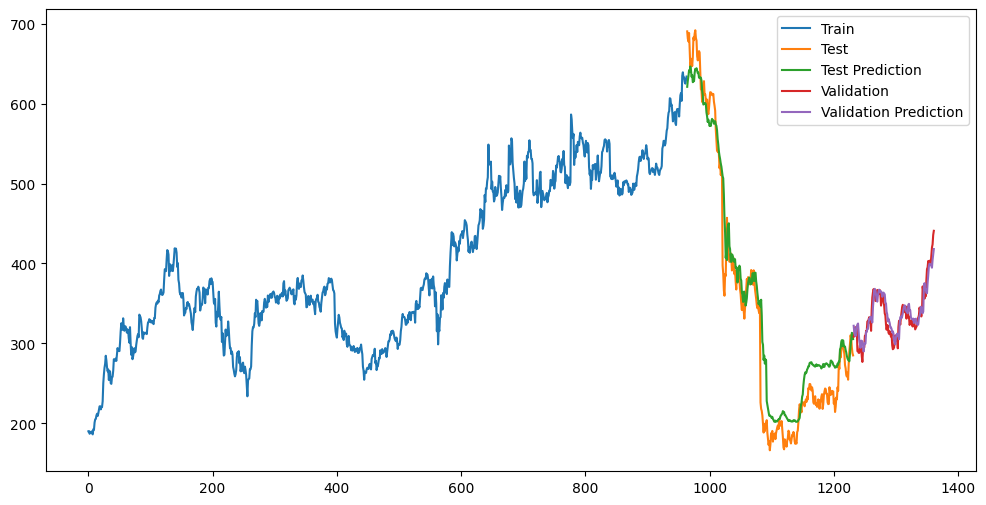

In [ ]:
visualization(model)

5/5 [==============================] - 0s 2ms/step


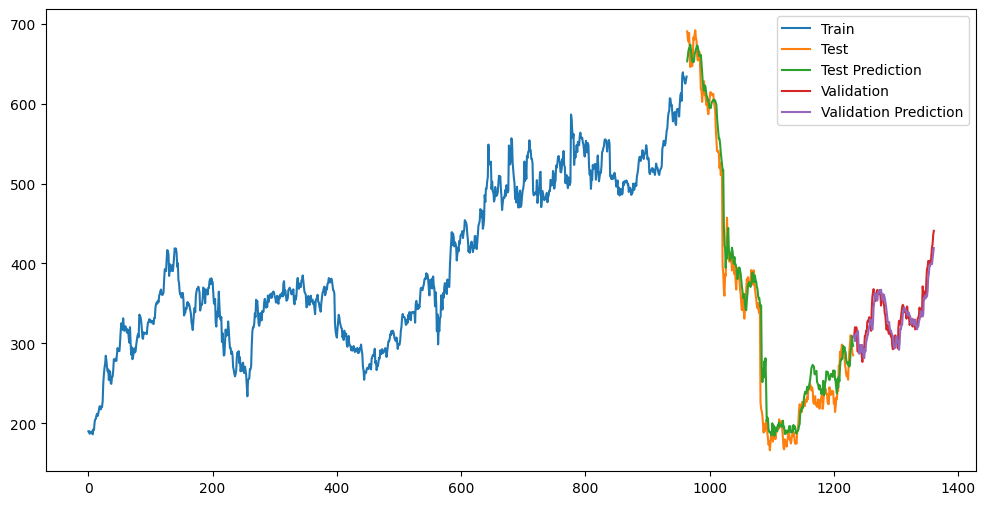

In [ ]:
visualization(model_best)

In [ ]:

# dates = df.index

# # Plot the training data
# plt.figure(figsize=(12, 8))
# plt.plot(dates[:len(train_actual)], train_actual, label='Train')

# # Plot the validation data
# test_offset = len(train_actual)
# plt.plot(dates[test_offset:test_offset + len(test_actual)], test_actual, label='Test')
# plt.plot(dates[test_offset:test_offset + len(test_predictions)], test_predictions, label='Test Predictions')

# # Plot the testing data
# val_offset = test_offset + len(test_actual)
# plt.plot(dates[val_offset:val_offset + len(val_actual)], val_actual, label='Validation')
# plt.plot(dates[val_offset:val_offset + len(val_predictions)], val_predictions, label='Validation Predictions')

# predicted_values = predict_future(model, number_days)
# next30days_offset = pd.date_range(start=dates[-1], periods=31, closed='right')
# plt.plot(next30days_offset, predicted_values, label='30 next days')

# # Rotate x-axis labels for better visibility
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()
